##### In this project we will be analyzing the stockprice of a single company and then we will predict and analyze the future stock price of that company

### Q. How to get the dataset?

- Step 1: go to pandas_datareader website [ https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#tiingo ]
- Step 2: go to Tiingo and open it in new tab
- Step 3: Login on tiingo and get the api key with following steps:

Log-in with user name and password --> click on api on the left --> Click on Documentation --> Scroll down and get the API

In [1]:
import pandas_datareader as pdr

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
data = pdr.get_data_tiingo("AAPL", api_key = "e335c58c7e1ae3b925d4fc44034dab6315b0eb26")

In [3]:
data.to_csv("AAPL.csv")

In [4]:
import pandas as pd
data = pd.read_csv("AAPL.csv")

In [5]:
data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-07-06 00:00:00+00:00,126.00,126.23,124.85,124.94,28060431,116.111949,116.323899,115.052197,115.135134,28060431,0.0,1.0
1,AAPL,2015-07-07 00:00:00+00:00,125.69,126.15,123.77,125.89,46946811,115.826276,116.250177,114.056951,116.010581,46946811,0.0,1.0
2,AAPL,2015-07-08 00:00:00+00:00,122.57,124.64,122.54,124.48,60761614,112.951123,114.858677,112.923478,114.711233,60761614,0.0,1.0
3,AAPL,2015-07-09 00:00:00+00:00,120.07,124.06,119.22,123.85,78595038,110.647315,114.324193,109.864020,114.130673,78595038,0.0,1.0
4,AAPL,2015-07-10 00:00:00+00:00,123.28,123.85,121.21,121.94,61354474,113.605405,114.130673,111.697851,112.370564,61354474,0.0,1.0


In [6]:
data.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1254,AAPL,2020-06-26 00:00:00+00:00,353.63,365.3200,353.02,364.41,51314211,353.63,365.3200,353.02,364.41,51314211,0.0,1.0
1255,AAPL,2020-06-29 00:00:00+00:00,361.78,362.1736,351.28,353.25,32661519,361.78,362.1736,351.28,353.25,32661519,0.0,1.0
1256,AAPL,2020-06-30 00:00:00+00:00,364.80,365.9800,360.00,360.08,35055821,364.80,365.9800,360.00,360.08,35055821,0.0,1.0
1257,AAPL,2020-07-01 00:00:00+00:00,364.11,367.3600,363.91,365.12,27690454,364.11,367.3600,363.91,365.12,27690454,0.0,1.0
1258,AAPL,2020-07-02 00:00:00+00:00,364.11,370.4700,363.64,367.85,28814516,364.11,370.4700,363.64,367.85,28814516,0.0,1.0


### Therefore, we have data from 6th July 2015 to 2nd July 2020

In [7]:
# We will use the close column and will make prediction using the close column (We have selected only the "close" column in data2 dataset)
data2 = data.reset_index()["close"]

In [8]:
data2.shape

(1259,)

In [9]:
data2

0       126.00
1       125.69
2       122.57
3       120.07
4       123.28
         ...  
1254    353.63
1255    361.78
1256    364.80
1257    364.11
1258    364.11
Name: close, Length: 1259, dtype: float64

In [10]:
data3 = pd.DataFrame(data2)

In [11]:
data3.reset_index(inplace = True)

In [12]:
data3.columns = ["counts", "price"]

In [13]:
# Graphical representation of data2

import plotly.express as px

df = px.data.gapminder().query("country=='Canada'")
fig = px.line(data3, x="counts", y="price", title='Stock Price Of Apple')
fig.show()


### LSTM is very SENSITIVE to the SCALE of Data. Hence we make use of min-max scaler

In [14]:
import numpy as np

In [15]:
data2

0       126.00
1       125.69
2       122.57
3       120.07
4       123.28
         ...  
1254    353.63
1255    361.78
1256    364.80
1257    364.11
1258    364.11
Name: close, Length: 1259, dtype: float64

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(data2).reshape(-1,1))

In [17]:
df1

array([[0.12911402],
       [0.1279916 ],
       [0.11669503],
       ...,
       [0.9937362 ],
       [0.99123792],
       [0.99123792]])

#### All the values in data2 array have been converted between 0 to 1 and have been named as df1

## For Time-Series Data, the data is divided into train_test_split in a different format

- We should try to divide the data based on date. We should not divide the data randomly as next date data is dependent on previous days data. 

In [18]:
# Splitting the data into train test split
training_size = int(len(df1)*0.65) # Training data size is 65%
test_size = len(df1) - training_size # Test data size is 35%
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1), :1]

In [19]:
training_size, test_size

(818, 441)

In [20]:
len(train_data), len(test_data)

(818, 441)

Hence the taining size and length of training data match and similarly test_size and length of test data match

## Data Preprocessing

- We will consider some timesteps to make the predictions
- Timesteps are basically number of previous days data required to predict the future data

- Eg: Train data = 120, 130, 140, 165, 170, 161 Test data = 170, 184, 190, 195, 180

- Let timesteps = 3 [3 days]

- Therefore, the independent features will be previous 3 days data in the training set and the dependent features will be the 4th day data

----------------------------------------------------------------------

- X_train         y_train
----------------------------
- f1    f2    f3     o/p
---------------------------------
- 120  130   140     165  [we move one step forward in the training set]
---------------------------------
- 130  140   165     170
---------------------------------
- 140  165   170     161

- This is how we create X_train and y_train from training data
- Similarly we create X_test and y_test from test data

In [21]:
import numpy as np
# convert an array of values into dataset matrix
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [], []
  for i in range(len(dataset) - time_step - 1):
    a = dataset[i:(i+time_step), 0] ##i = 0,1,2,3
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY) 

In [22]:
# Reshape into X = t, t+1, t+2, t+3 and Y = t+4

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [23]:
print(X_train)

[[0.12911402 0.1279916  0.11669503 ... 0.10297259 0.10485535 0.09924327]
 [0.1279916  0.11669503 0.10764329 ... 0.10485535 0.09924327 0.10333466]
 [0.11669503 0.10764329 0.11926572 ... 0.09924327 0.10333466 0.10025707]
 ...
 [0.33849886 0.34331439 0.3465368  ... 0.460987   0.47231978 0.47738875]
 [0.34331439 0.3465368  0.35127992 ... 0.47231978 0.47738875 0.47098012]
 [0.3465368  0.35127992 0.36098338 ... 0.47738875 0.47098012 0.48738187]]


In [24]:
X_train.shape, y_train.shape

((717, 100), (717,))

#### Since timestep = 100, we see that there are 100 columns that have been created for each entry 

In [25]:
X_test.shape, y_test.shape

((340, 100), (340,))

### Before creating a LSTM model we have to reshape X_train and X_train both to 3-dimension

The 3 dimensions are: number of records(rows), timesteps and 1

In [26]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
## Creating a LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [38]:
model = Sequential() 
model.add(LSTM(50, return_sequences= True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences= True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [39]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# fitting the model

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size= 64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 3s 279ms/step - loss: 0.0143 - val_loss: 0.0541
Epoch 2/100
12/12 [==============================] - 2s 186ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 3/100
12/12 [==============================] - 2s 189ms/step - loss: 9.8123e-04 - val_loss: 0.0037
Epoch 4/100
12/12 [==============================] - 2s 190ms/step - loss: 6.4791e-04 - val_loss: 0.0035
Epoch 5/100
12/12 [==============================] - 2s 189ms/step - loss: 4.9632e-04 - val_loss: 0.0043
Epoch 6/100
12/12 [==============================] - 2s 189ms/step - loss: 4.5126e-04 - val_loss: 0.0030
Epoch 7/100
12/12 [==============================] - 2s 193ms/step - loss: 4.3565e-04 - val_loss: 0.0030
Epoch 8/100
12/12 [==============================] - 2s 197ms/step - loss: 4.2840e-04 - val_loss: 0.0030
Epoch 9/100
12/12 [==============================] - 2s 193ms/step - loss: 4.3053e-04 - val_loss: 0.0029
Epoch 10/100
12/12 [==============================] - 2s 191ms/

In [42]:
import tensorflow as tf

In [43]:
# Lets do the prediction and check the performance metrics

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [44]:
# Tramsform the data back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [45]:
## Calculating the RMSE performance Metrics

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

146.28376979627362

In [46]:
# Test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

252.87026483347665

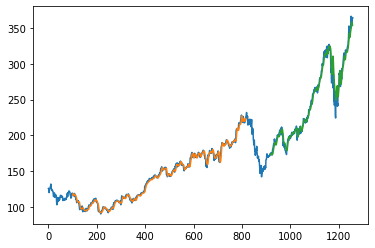

In [53]:
### Plotting 
# shift train predictions for plotting
import matplotlib.pyplot as plt
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Here, the blue line is the actual values, orange line is the training prediction and green line is test prediction


### Predicting the output for next 30 days

In [47]:
len(test_data)

441

In [48]:
# Taking the data of last 100 days

x_input = test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [49]:
# Converting the X input to list

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [54]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:]) # shifting one position to right and take the new i/p
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist()) # adding yhat to previous input
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1)) # These steps happen before if statement. reshape the new data
        yhat = model.predict(x_input, verbose=0) # making prediction
        print(yhat[0]) #printing yhat
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist()) #adding yhat value to the final o/p
        i=i+1
    

print(lst_output) #printing the final o/p

[0.9697428]
101
1 day input [0.85759803 0.84916181 0.84945146 0.82790832 0.84463594 0.83261523
 0.80636518 0.75252544 0.71595641 0.73250299 0.66323907 0.66265976
 0.75480647 0.72044607 0.76903581 0.73348057 0.71939607 0.63662696
 0.7060357  0.6701546  0.57167168 0.67935117 0.54987509 0.5884355
 0.56602339 0.55918027 0.50291466 0.48528187 0.56678374 0.56185959
 0.60863898 0.56989753 0.59549585 0.59361309 0.54516818 0.55972338
 0.54697853 0.62323038 0.61222347 0.63626489 0.64321663 0.66226149
 0.71222709 0.70274087 0.71092364 0.69683913 0.67558565 0.64459249
 0.67258047 0.66870633 0.69745465 0.69817879 0.6815598  0.71468916
 0.73666679 0.7195409  0.73434954 0.7502806  0.76139614 0.7726565
 0.79579275 0.81346175 0.80042724 0.78681343 0.79365654 0.78703067
 0.81328071 0.80669105 0.82874108 0.82012383 0.82751005 0.81968934
 0.8246859  0.8251928  0.82407039 0.83822731 0.84362214 0.85006698
 0.83992903 0.87316702 0.88026359 0.91838951 0.95043267 0.88909808
 0.8995981  0.91476882 0.94768094 0.

In [55]:
#plotting the o/p

day_new = np.arange(1,101) # taking 100 previous days indexes that the model will look at
day_predict = np.arange(101,131) # taking indexes of predictions for the next 100 days

In [56]:
import matplotlib.pyplot as plt

In [57]:
len(df1)

1259

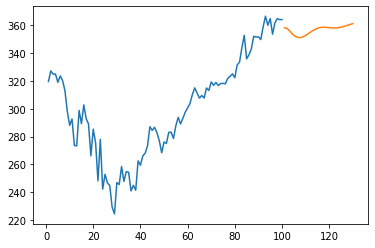

In [58]:
plt.plot(day_new, scaler.inverse_transform(df1[1159:])) #We have taken 1159 coz total values in df1 is 1259 and we need last 100 days data
plt.plot(day_predict,scaler.inverse_transform(lst_output))

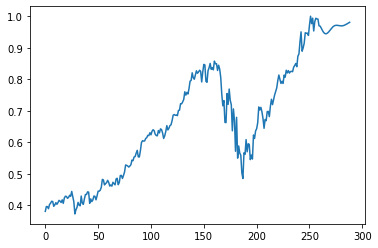

In [61]:
# Proper plotting of the output

df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:]) # Data after previous 1000 days 